In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session (engine)

In [9]:
# Obtain overview of the Measurement table
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25c78f4a370>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

In [10]:
# Obtain overview of the Station table
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25c75f93580>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
newest_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print("Most recent date in the dataset is " + newest_date.date + ".")

Most recent date in the dataset is 2017-08-23.


2016-08-23 00:00:00


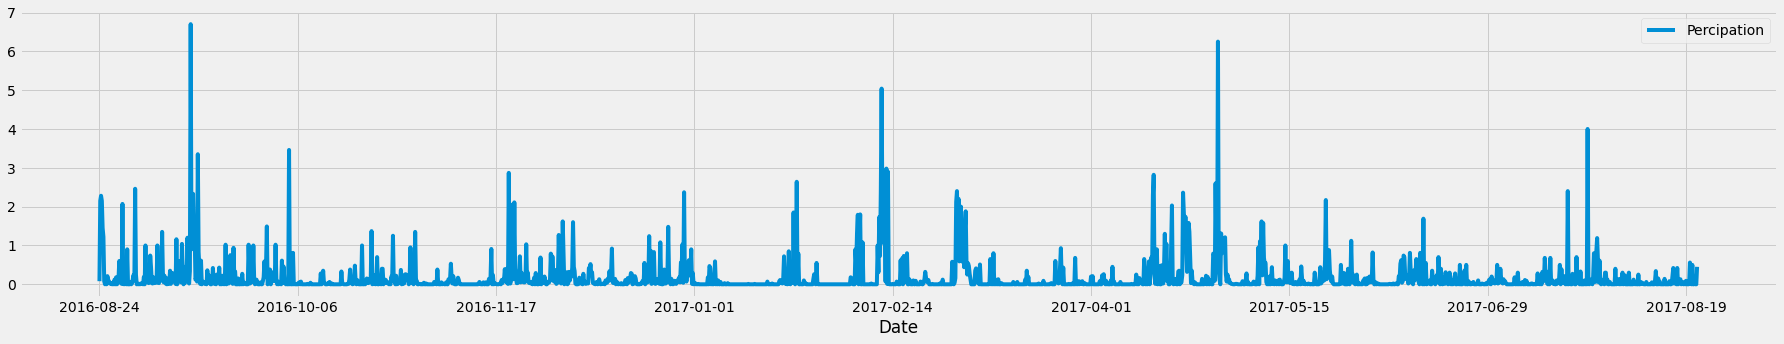

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime(2017,8,23)

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
percipation_results = session.query(Measurement.prcp,Measurement.date).\
    filter(Measurement.date > one_year_ago).filter(Measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
percipation_rows = [{"Date": result[1],"Percipation": result[0]} for result in percipation_results]
# check: percipation_rows

# Sort the dataframe by date
percipation_df = pd.DataFrame(percipation_rows).set_index("Date")
percipation_df = percipation_df.sort_values(["Date"], ascending=True)

# drop NA
percipation_df = percipation_df.dropna()


# Use Pandas Plotting with Matplotlib to plot the data
percipation_df.plot(kind="line", figsize=(25,5))
plt.tight_layout()
# percipation_df.iloc[::-1].plot.bar(title="Daily Percipation (last 12 months)")
# plt.tight_layout()
# plt.show


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percipation_df.describe()

,Percipation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
#stations_qty = session.query(Station).count()
stations_qty = session.query(Measurement).group_by(Measurement.station).count()
print(f"Total number of stations in the dataset is {stations_qty}.")

Total number of stations in the dataset is 9.


In [61]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

# Query the Measurement table and create a dataframe
station_activity = session.query(Measurement.station, Measurement.tobs, Measurement.date).all()
station_activity_rows = [{"Station ID": result[0], "Temperature Count": result[1]} for result in station_activity]
station_activity_df = pd.DataFrame(station_activity_rows)

# create Station dataframe
stations = session.query(Station.station, Station.name).all()
station_rows = [{"Station ID": result[0],"Name": result[1]} for result in stations]
station_df = pd.DataFrame(station_rows)

# List the stations and the counts in descending order.
group_station_activity_df = station_activity_df.groupby(["Station ID"])
station_activity_count = group_station_activity_df.count().sort_values("Temperature Count",ascending=False)

# Merge station_activity_count with station_df to retrieve the station name
merged_station_activity = pd.merge(station_activity_count,station_df, on=["Station ID"])
merged_station_activity


,Station ID,Temperature Count,Name
0,USC00519281,2772,"WAIHEE 837.5, HI US"
1,USC00519397,2724,"WAIKIKI 717.2, HI US"
2,USC00513117,2709,"KANEOHE 838.1, HI US"
3,USC00519523,2669,"WAIMANALO EXPERIMENTAL FARM, HI US"
4,USC00516128,2612,"MANOA LYON ARBO 785.2, HI US"
5,USC00514830,2202,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
6,USC00511918,1979,"HONOLULU OBSERVATORY 702.2, HI US"
7,USC00517948,1372,"PEARL CITY, HI US"
8,USC00518838,511,"UPPER WAHIAWA 874.3, HI US"


In [62]:
# Retrieve the most active station
most_active_station_id = merged_station_activity["Station ID"].iloc[0]
most_active_station_name = merged_station_activity["Name"].iloc[0]
print(f"The most active station is {most_active_station_name} (station ID: {most_active_station_id}).")


The most active station is WAIHEE 837.5, HI US (station ID: USC00519281).


In [63]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temp = [{"Station ID": result[0], "Temperature": result[1]} for result in station_activity]
station_temp_df = pd.DataFrame(station_temp)
most_active_station_temp = station_temp_df.loc[station_temp_df["Station ID"] == most_active_station_id]

average_temp = most_active_station_temp["Temperature"].mean()
lowest_temp = most_active_station_temp["Temperature"].min()
highest_temp = most_active_station_temp["Temperature"].max()

print(f"From station {most_active_station_name}: lowest temperature is {lowest_temp}, highest temperature is {highest_temp}, average temperature is {average_temp}")

From station WAIHEE 837.5, HI US: lowest temperature is 54.0, highest temperature is 85.0, average temperature is 71.66378066378067


<function matplotlib.pyplot.show(close=None, block=None)>

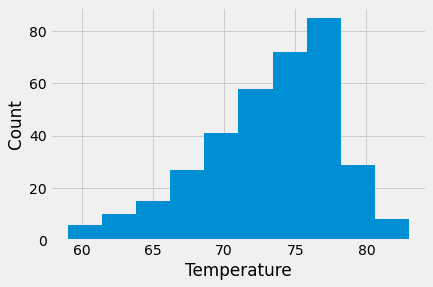

In [76]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_one_year_temp = session.query(Measurement.station, Measurement.tobs, Measurement.date).\
    filter(Measurement.date > one_year_ago).filter(Measurement.date <= most_recent_date).filter(Measurement.station == most_active_station_id).all()

station_one_year_temp_rows = [{"Temperature": result [1]} for result in station_one_year_temp]

station_one_year_temp_df = pd.DataFrame(station_one_year_temp_rows)

plt.hist(station_one_year_temp_df["Temperature"])
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.show    

# Close session

In [77]:
# Close Session
session.close()